# A Comparison of St-DBSCAN And DBSCAN In Identifying Density Clusters of Antisocial Behaviour across Greater London

This notebook aims to use unsupervised machine learning algorithms, DBSCAN and ST-DBSCAN, to identify regions in Greater London with high densities of Antisocial Behaviour crimes.

In [2]:
#Install and import the required packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn 
import matplotlib.patches as mpatches
from sklearn.cluster import  DBSCAN
from st_dbscan import ST_DBSCAN

##  Load the Crime CSV and LSOA boundary Shapefile

In [22]:
#Find the path of the ASB crime data, then upload it into a Pandas DataFrame
crime_csv ="Files/St_DBSCAN_BNG.csv"
data= pd.read_csv (crime_csv)



In [23]:
#Find the path of the shapefile of the London Boroughs. Load It then set the CRS to 27700
file ="Files/London_borough_BNG,2770.shp"
gdf= gpd.read_file(file)


## Visualise the crime data over the London shapefile

In [25]:
# Initial visualisation of the data 
#Creating legend patches for the plot
April_patch = mpatches.Patch(color='teal', label='April')
May_patch = mpatches.Patch(color='yellow', label='May')
June_patch = mpatches.Patch(color='mediumseagreen', label='June')
July_patch = mpatches.Patch(color='navy', label='July')
August_patch = mpatches.Patch(color='purple', label='August')
     

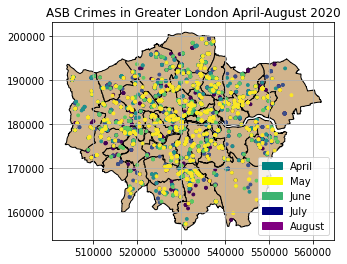

In [26]:
#Plotting the entire data over a shapefile of the London boroughs 
gdf.plot(color='tan', edgecolor='black')
plt.scatter(x=data['Eastings'],y=data['Northings'],s=8,c=data['Time'])
plt.grid(True)
plt.legend(handles=[April_patch,May_patch,June_patch,July_patch,August_patch])
plt.title('ASB Crimes in Greater London April-August 2020', fontsize=12)
plt.show()

## Create DataFrames of the individual months 

In [27]:
# Create DataFrames of the individual months 
April_data= data.iloc[:1500,]
May_data= data.iloc[1500:2820,]
June_data= data.iloc[2820:3664,]
July_data=data.iloc[3664:4416,]
August_data=data.iloc[4416:,]


# Exploratory Data Analysis

## kernel Density Estimation plots of the Crime data

In [14]:
def kde_figures(data,number, month):
    """ The Plotting function takes in a dataframe containing the values of Time, Eastings,
    Northings etc and plots a KDE plot
    
    Params
    data: dataframe containng Eastings and Northings
    number: a random number to set the axis so its not repeates
    month: string for the title
    f"""
    f, number = plt.subplots(1, figsize=(7, 5))
    gdf.plot(color='tan', edgecolor='black',ax=number)
    seaborn.kdeplot( ax=number,x=data['Eastings'],y=data['Northings'],data=data, 
                     alpha=0.5, cmap='viridis',cbar=True,fill=True,)
    number.set_title('ASB Crimes in Greater London, '+str(month)+' 2020',fontsize=12);
    plt.show()
    


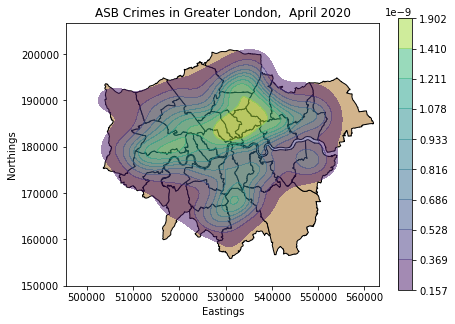

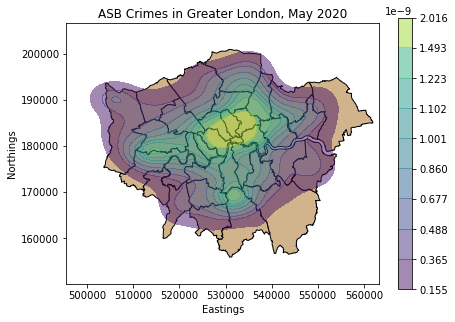

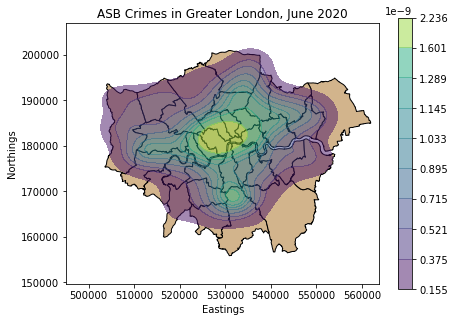

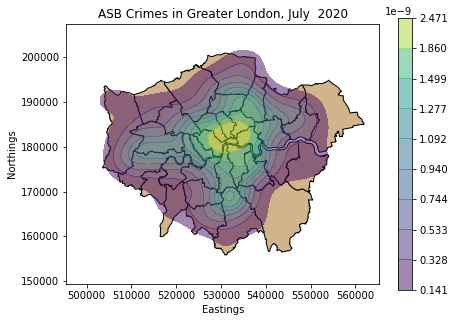

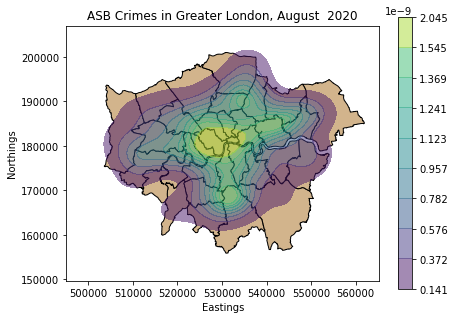

In [15]:
 # Creating Seaborn KDE plots of crimes in the individual months
kde_figures(April_data, 3, ' April')
kde_figures(May_data, 4, 'May')
kde_figures(June_data, 6, 'June')
kde_figures(July_data, 7, 'July ')
kde_figures(August_data, 5, 'August ')

# Data Conversion of Machine Learning Algorithms 

In [16]:

#extract time and location into DataFrames
location = data[['Eastings','Northings']]
time = data[['Time']]

In [17]:
#Changing time data frame to array
location_array=location.values.astype('float32', copy=False)
#changing long and lat to array
time_array = time.values.astype('float32', copy=False)

In [18]:
# concatenate the two arrays
numpy_data= np.concatenate((time, location_array[:,0:1], location_array[:,1:]),axis=1)

## Plotting the Cluster Results

In [19]:
# code adapted from Eren Cakmak, https://github.com/eren-ck/st_dbscan
def plot(numpy_data, labels,title):
    """
    Plots the ST-DBSCAN AND DBSCAN Results
    Params:
    numpy_data: Array of Eastings an northings 
    labels : Labels reuslts for density clustering alogrithm 
    title: string for the tile of the plot
    
    """
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    gdf.plot(color='tan', edgecolor='black')
    plt.grid()
    for i in range(-1, len(set(labels))):
        if i == -1:
            col = [0, 0, 0, 1]
        else:
            col = colors[i % len(colors)]
        
        clust = numpy_data[np.where(labels==i)]
    
        plt.title( title)
        plt.scatter(clust[:,0], clust[:,1], c=[col], s=10,)
        
    
    plt.show()

# Parameter selection  

2500m was chosen Epsilon 1, representing the radius in metres defining the crime locations neighbourhood. The Figure is approximately half the observed mean value of the distance between the centroids of each borough in the London shapefile (QGIS), representing the average radius of each borough. 


147 was selected as the MinPts value of points to create a cluster. 147 was the median value when a select point count operation (QGIS) was carried out for each borough for the total ASB crimes in the period. The median is the statistical separation between high and low values in a dataset, designating it a suitable parameter choice in the absence of literature-based guidance. Epsilon 2 value was iterated through different values to observe how the change in months influenced the clusters; values ranged from 1, creating a temporal neighbour of one month to 4, which would be the same as a DBSCAN.


# DBSCAN

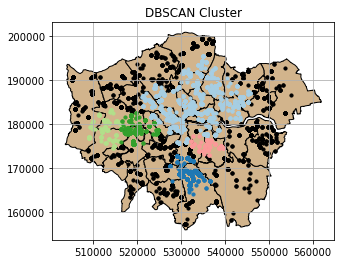

In [20]:
# Run the mode the location array is th data that will be fitted 
dbscan_model= DBSCAN(eps=2589, min_samples=147, metric='euclidean' ).fit(location_array)   
plot(numpy_data[:,1:3], dbscan_model.labels_, 'DBSCAN Cluster') 


# ST-DBSCAN

[-1  0  1  2  3]min sample size147Eps21


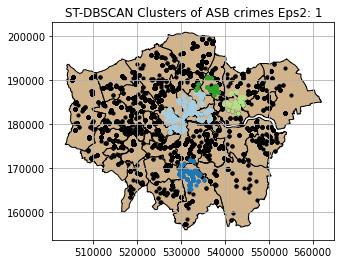

[-1  0  1  2  3  4  5]min sample size147Eps22


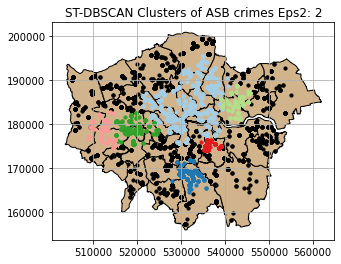

[-1  0  1  2  3  4]min sample size147Eps23


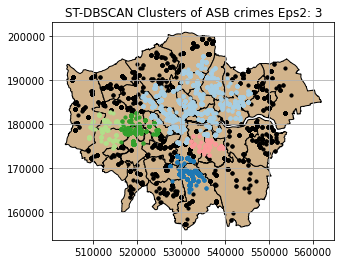

[-1  0  1  2  3  4]min sample size147Eps24


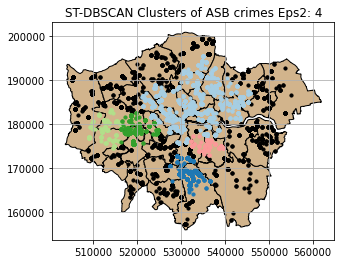

In [28]:
# Running the ST-DBSCAN algorithm iterating through Eps2 
# to observe how temporal dimension changes influence clusters
epsilon2=[1,2,3,4]
for st_eps2 in epsilon2:
    st_dbscan = ST_DBSCAN(eps1 = 2589, eps2 = st_eps2, min_samples = 147) 
    st_dbscan.fit(numpy_data) 
    print(str(np.unique(st_dbscan.labels))+'min sample size'+str(st_dbscan.min_samples)+'Eps2'+str(st_dbscan.eps2))
    # plt.title( 'ST-DBSCAN Clusters of ASB crimes '+'Eps2: ' + str(st_eps2))
    plot(numpy_data[:,1:3], st_dbscan.labels,'ST-DBSCAN Clusters of ASB crimes '+'Eps2: ' + str(st_eps2)) 
    